
# MICCAI 2024 INR Tutorial
Welcome to the official notebook on Implicit Neural Representations (INR) for the MICCAI 2024 INR4MICCAI Tutorial.

**Code Repository**
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/INR4MICCAI/INRTutorial)   
**Filled notebooks**
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/INR4MICCAI/INRTutorial/blob/main/INR_Tutorial.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/INR4MICCAI/INRTutorial/blob/main/INR_Tutorial.ipynb)    
**Author**: Nil Stolt-Ansó   
**Contributors**: Thanks to Wenqi Huang for the contributions to the k-space section, as well as the review efforts by Julian McGinnis and Vasiliki Sideri-Lampretsa.   

# What are Implicit Neural Representations?


INRs are learned mappings from a coordinate system to an arbitrary function.

An INR typically involves a multi-layer perceptron (MLP) being trained to take in a coordinate as input, and output the value of the function at that coordinate.

<center width="100%" style="padding:25px"><img src="https://www.researchgate.net/publication/346302971/figure/download/fig1/AS:961682037829650@1606294273728/An-illustration-of-an-image-represented-in-the-implicit-neural-representation-INR-form.png" width="400px"></center>

Once trained, we no longer need the explicit data it was trained on. The INR can be said to be __implicitly__ representing the function in the weights of the neural network, hence its name.

The type of functions we try to represent wildly vary depending on the application:
*   Image intensities (gray-scale, RGB, ...)
*   Shapes (occupancy values, signed distances, ...)
*   Vector fields (deformations, velocities, ...)




# Training a simple INR

In this section we will train our first INR on medical images from the MedMNIST dataset. We will take a look at the structure of the training data, build a simple training loop, and plot the reconstructions of our learned representation.


In [1]:
# Colab requirements:
# !apt-get install git
# !pip install medmnist --quiet
# !pip install torch --quiet
# !pip install torchvision --quiet
# !pip install lightning  --quiet
# !pip install matplotlib --quiet
# !pip install scipy==1.11.3 --quiet
# !pip torchkbnufft scipy==1.11.3 --quiet
# import torch
# torch.cuda.is_available()


## INR architecture

Let us begin by creating our INR architecture.

Implicit Neural Representations are typically defined as a series of dense layers with non-linear activation functions. The network is meant to learn a mapping between coordinates and the value of a function at those coordinates.


We will start by creating a network with ReLU layers. As we will see later in this tutorial, the naive use of Rectified Linear Units (ReLU) does not produce ideal results. For this reason, we will allow our INR class to make use of easily-swappable layers in make use of fancier layers later in the tutorial.

In [2]:
import torch
from torch import nn

class ReLULayer(nn.Module):
    def __init__(self,
                 in_size: int,
                 out_size: int,
                 **kwargs):
        super().__init__()
        self.linear = nn.Linear(in_size, out_size, bias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear(x)
        x = torch.relu(x)
        return x


class MLP(nn.Module):
    def __init__(self,
                 in_size: int,
                 out_size: int,
                 hidden_size: int = 128,
                 num_layers: int = 3,
                 layer_class: nn.Module = ReLULayer,
                 **kwargs):
        super().__init__()

        a = [layer_class(in_size, hidden_size, **kwargs)]
        for i in range(num_layers - 1):
            a.append(layer_class(hidden_size, hidden_size, **kwargs))
        a.append(nn.Linear(hidden_size, out_size))
        self.layers = nn.ModuleList(a)        

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x


## Data loading

For starters, we will use the ChestMNIST dataset. A dataset of gray-scale chest X-ray images.

Unlike other areas of machine learning, we don't aim to generalize to unseen subjects. INRs are trained on exclusively one subject and aim to generalize onto unseen coordinates.

We will thus download only 1 image and aim to see how well the network is able to interpolate the image into arbitrary resolutions.


Using downloaded and verified file: C:\Users\nilst\.medmnist\pneumoniamnist_224.npz
Image shape: torch.Size([224, 224, 1])
Max: tensor(0.8980) Min: tensor(0.)


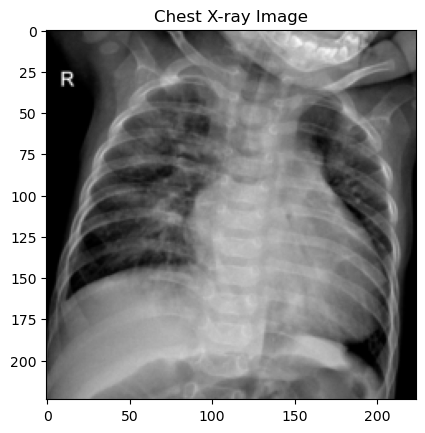

In [3]:
from medmnist import BreastMNIST, RetinaMNIST, PneumoniaMNIST
from torchvision.transforms.functional import pil_to_tensor
import matplotlib.pyplot as plt

IMAGE_SIZE = 224  # ChestMNIST offers sizes: 28, 64, 128, 224
chest_dataset = PneumoniaMNIST(split="val",
                           download=True,
                           size=IMAGE_SIZE)

# INRs are trained on only 1 scene. We only want 1 image.
pil_image, _ = chest_dataset[1]

gt_image = pil_to_tensor(pil_image)
gt_image = gt_image.moveaxis(0, -1)  # Convert to torch.Tensor
gt_image = gt_image.to(torch.float32) / 255.0  # Normalize image between [0.0, 1.0]
print("Image shape:", gt_image.shape)
print("Max:", gt_image.max(), "Min:", gt_image.min())
plt.imshow(gt_image, cmap='gray')
plt.title('Chest X-ray Image')
plt.show()


Since the network takes in only takes in one coordinate at a time, we want our dataloader to yield batches of coordinate-value pairs (as opposed to pairs of whole images and their coorresponding ground-truths like in other areas of supervised learning).


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np


POINTS_PER_SAMPLE = 2048

class RandomPointsDataset(Dataset):
    def __init__(self, image: torch.Tensor, points_num: int = POINTS_PER_SAMPLE):
        super().__init__()
        self.device = "cpu"
        self.points_num = points_num
        assert image.dtype == torch.float32
        self.image = image.to(self.device)  # (H, W, ..., C)
        self.dim_sizes = self.image.shape[:-1]  # Size of each spatial dimension

        # To help us define the input/output sizes of our network later
        # we store the size of our input coordinates and output values
        self.coord_size = len(self.image.shape[:-1])  # Number of spatial dimensions
        self.value_size = self.image.shape[-1]  # Channel size

    def __len__(self):
        return 1

    def __getitem__(self, idx: int):
        # Create random sample of pixel indices
        point_indices = [torch.randint(0, i, (self.points_num,), device=self.device) for i in self.dim_sizes]

        # Retrieve image values from selected indices
        point_values = self.image[tuple(point_indices)]

        # Convert point indices into normalized [-1.0, 1.0] coordinates
        point_coords = torch.stack(point_indices, dim=-1)
        spatial_dims = torch.tensor(self.dim_sizes, device=self.device)
        point_coords_norm = point_coords / (spatial_dims / 2) - 1

        # The subject index is also returned in case the user wants to use subject-wise learned latents
        return point_coords_norm, point_values

dataset = RandomPointsDataset(gt_image, points_num=POINTS_PER_SAMPLE)
# We set a batch_size of 1 since our dataloader is already returning a batch of points.
dataloader = DataLoader(dataset, batch_size=1, num_workers=0, pin_memory=True)

## Optimization

Finally, we will use Pytorch Lightning to create simple training procedure. We will use the Adam optimizer with a learning rate of 0.001.

As we train, we will plot the reconstructed images at certain intervals to visualize the reconstruction fidelity of our INR.

In [5]:
from typing import Tuple, List, Optional
import numpy as np
import torch
import matplotlib.pyplot as plt

In [6]:
# We will track visual results every few epochs and visualize them after training
def plot_reconstructions(progress_ims: List[Tuple[int, torch.Tensor]], gt_im: torch.Tensor):
    ncols = len(progress_ims) + 1
    fig_width = 5
    fig, axs = plt.subplots(ncols=ncols, figsize=(ncols*fig_width, fig_width))
    # Plot all reconstructions images predicted by the model
    for i, (epoch, im, metric) in enumerate(progress_ims):
        im = im.cpu().numpy()
        ax = axs[i]
        ax.imshow(im, cmap='gray')
        ax.axis('off')
        title = f'Epoch: {epoch}, PSNR: {metric}'
        ax.set_title(title)
    # PLot ground-truth image
    gt_im = gt_im.cpu().numpy()
    axs[-1].imshow(gt_im, cmap='gray')
    axs[-1].axis('off')
    axs[-1].set_title('Ground Truth')
    plt.tight_layout()
    plt.show()

# We will also track the PSNR of our training samples
def psnr(pred, ref):
    max_value = ref.max()
    mse = torch.mean((pred - ref) ** 2, dim=(-2, -1))
    out = 20 * torch.log10(max_value / torch.sqrt(mse))
    return out.mean()

# Let's create a function to plot our psnr scores throughout training
def plot_scores(models: List['INRModule']):
    fig, ax = plt.subplots()
    # For each model, plot list of scores
    for model in models:
        epochs, scores = [i for i, _ in model.scores], [v for _, v in model.scores]
        ax.plot(epochs, scores, label=model.name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('PSNR')
    ax.set_title('PSNR over epochs')
    ax.legend()
    plt.show()

In [7]:
from torch import nn
import lightning as pl

class INRLightningModule(pl.LightningModule):
    def __init__(self,
                 network: MLP,
                 gt_im: torch.Tensor,
                 lr: float = 0.001,
                 name: str = "",
                 eval_interval: int = 100,
                 visualization_intervals: List[int] = [0, 100, 500, 1000, 5000],
                ):
        super().__init__()
        self.lr = lr
        self.network = network

        # Logging
        self.name = name
        self.gt_im = gt_im
        self.eval_interval = eval_interval
        self.visualization_intervals = visualization_intervals
        self.progress_ims = []
        self.scores = []

    def configure_optimizers(self):
        return torch.optim.Adam(self.network.parameters(), lr=self.lr)

    def forward(self, coords):
        return self.network(coords)

    def training_step(self, batch, batch_idx):
        coords, values = batch
        coords = coords.view(-1, coords.shape[-1])
        values = values.view(-1, values.shape[-1])
        outputs = self.forward(coords)
        loss = nn.functional.mse_loss(outputs, values)
        return loss

    def on_train_epoch_end(self):
        """ At each visualization interval, reconstruct the image using our INR """
        if (self.current_epoch + 1) % self.eval_interval == 0 or self.current_epoch == 0:
            pred_im = self.sample_at_resolution(self.gt_im.shape[:-1])
            pred_im = pred_im.reshape(self.gt_im.shape)
            psnr_value = psnr(pred_im, self.gt_im.to(pred_im.device)).cpu().item()
            self.scores.append((self.current_epoch + 1, psnr_value))  # Log PSNR
            if self.current_epoch + 1 in self.visualization_intervals:
                self.progress_ims.append((self.current_epoch + 1, pred_im.cpu(), psnr_value))

    @torch.no_grad()
    def sample_at_resolution(self, resolution: Tuple[int, ...]):
        """ Evaluate our INR on a grid of coordinates in order to obtain an image. """
        meshgrid = torch.meshgrid([torch.arange(0, i, device=self.device) for i in resolution], indexing='ij')
        coords = torch.stack(meshgrid, dim=-1)
        coords_norm = coords / torch.tensor(resolution, device=self.device) * 2 - 1
        coords_norm_ = coords_norm.reshape(-1, coords.shape[-1])
        predictions_ = self.forward(coords_norm_)
        predictions = predictions_.reshape(resolution)
        return predictions

C:\Users\nilst\.conda\envs\cmr_ia\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [8]:
# Let's initialize our network
HIDDEN_SIZE = 128
NUM_LAYERS = 3

inr = MLP(dataset.coord_size,
          dataset.value_size,
          hidden_size=HIDDEN_SIZE,
          num_layers=NUM_LAYERS,
          layer_class=ReLULayer, 
         )

In [9]:
from datetime import datetime

# Let's initialize our lightning module
LEARNING_RATE = 1e-3
TRAINING_EPOCHS = 5000

inr_module = INRLightningModule(network=inr, 
                                lr=LEARNING_RATE,
                                gt_im=gt_image,
                                name='ReLU',
                                eval_interval=100,
                                visualization_intervals=[0, 100, 500, 1000, 5000, 10000],
                                )
trainer = pl.Trainer(max_epochs=TRAINING_EPOCHS)
s = datetime.now()
trainer.fit(inr_module, train_dataloaders=dataloader)
print(f"Fitting time: {datetime.now()-s}s.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | network | MLP  | 33.5 K
---------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)
C:\Users\nilst\.conda\envs\cmr_ia\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\nilst\.conda\envs\cmr_ia\lib\site-packages\lightning\pytorch\loops\fit_loop.py:281: PossibleUserWarning: The number of training batches (1) 

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Fitting time: 0:01:32.339330s.


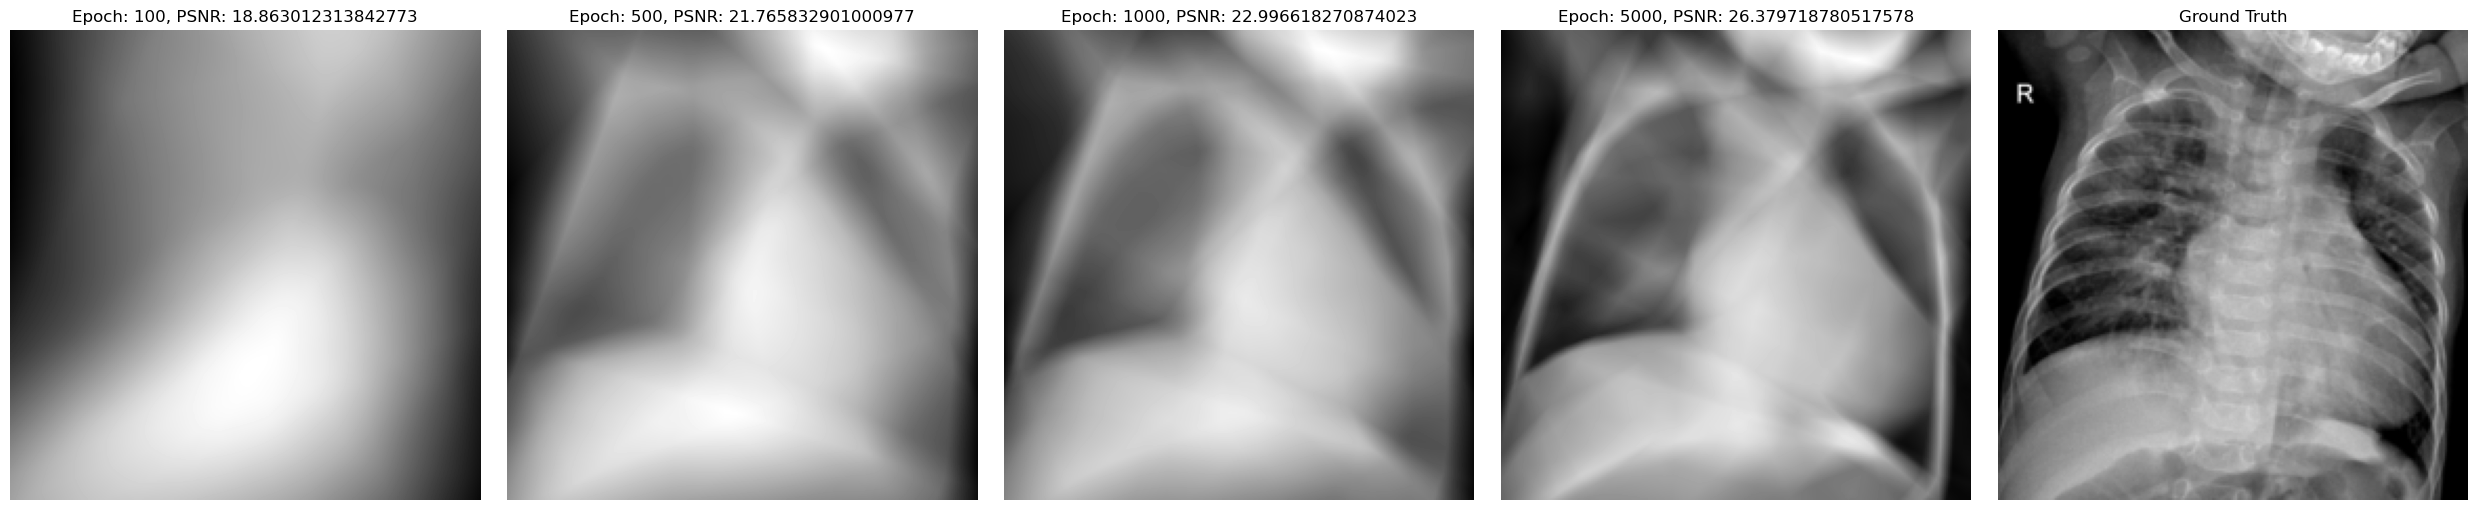

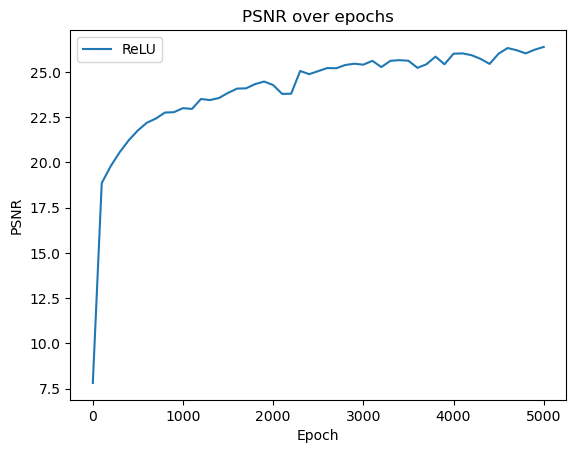

In [10]:
# Let's visualize the reconstruction progress during training!
plot_reconstructions(inr_module.progress_ims, gt_image)
plot_scores([inr_module])

# Architectural Improvements

Standard MLPs are known to fail to model the high frequency components of signals. This *spectral bias* causes INRs to produce blurry reconstructions such as the ones from our trained model above.

Let's see what can be done to improve reconstruction fidelity.


## Activation functions

Multiple papers propose alternate activation functions as a drop-in replacement for ReLU layers. These approaches base themselves on signal processing concepts and offer improvements in terms of robustness and reconstruction fidelity.   

### SIREN

One such INR variant are sinusoidal representation networks (SIREN) as proposed by the paper [*Implicit Neural Representations with Periodic Activation Functions*](https://www.vincentsitzmann.com/siren/). SIRENs replace ReLU activation functions with sinusoids.

<!-- <center width="100%" style="padding:25px"><img src="https://bmild.github.io/fourfeat/img/teaser.png" width="750px"></center>
 -->
<video id="" width="50%" autoplay="true" loop="true" muted="" controls="" src="https://www.vincentsitzmann.com/siren/img/bikes_comparison_label.mp4" type="video/mp4"> </video>

One important parameter to take into account is the *siren factor* $\omega_0$ which is used to scale the frequency of our layer activations. We can use this parameter to make the network better learn high spatial frequency components. A higher value of $\omega_0$ will allow the network to capture high-frequency components, but it will also introduce noisy artifacts into our reconstruction. The authors empirically propose a value of $\omega_0 = 30.0$.



In [11]:
SIREN_FACTOR = 30.0

class SineLayer(nn.Module):
    """
        Implicit Neural Representations with Periodic Activation Functions
        Implementation based on https://github.com/vsitzmann/siren?tab=readme-ov-file
    """
    def __init__(self, in_size, out_size, siren_factor=30., **kwargs):
        super().__init__()
        # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of factor 30
        self.siren_factor = siren_factor
        self.linear = nn.Linear(in_size, out_size, bias=True)

    def forward(self, x):
        x = self.linear(x)
        x = torch.sin(self.siren_factor * x)
        return x



The authors also emphasize the initialization of the weights as having a large impact on the convergence of the SIREN. Every layer after the first should be initialized with a distribution dependent on the $\omega_0$ value:  

$$ \hat{W} \sim \mathcal{U}\left(-\sqrt{\frac{c}{\omega_0^2 n}}, \sqrt{\frac{c}{\omega_0^2 n}}\right) $$

The authors propose a value of $c=6$.

We can then initialize our SIREN weights with the following function.

In [12]:
import math

def initialize_siren_weights(network: MLP, omega: float):
    """ See SIREN paper supplement Sec. 1.5 for discussion """
    old_weights = network.layers[1].linear.weight.clone()
    with torch.no_grad():
        # First layer initialization
        num_input = network.layers[0].linear.weight.size(-1)
        network.layers[0].linear.weight.uniform_(-1 / num_input, 1 / num_input)
        # Subsequent layer initialization uses based on omega parameter
        for layer in network.layers[1:-1]:
            num_input = layer.linear.weight.size(-1)
            layer.linear.weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        # Final linear layer also uses initialization based on omega parameter
        num_input = network.layers[-1].weight.size(-1)
        network.layers[-1].weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        
    # Verify that weights did indeed change
    new_weights = network.layers[1].linear.weight
    assert (old_weights - new_weights).abs().sum() > 0.0

In [13]:
# We use the same MLP class as before, but give it our new SIREN layers
siren_inr = MLP(dataset.coord_size,
                dataset.value_size,
                hidden_size=HIDDEN_SIZE,
                num_layers=NUM_LAYERS,
                layer_class=SineLayer, 
                siren_factor=SIREN_FACTOR,
                )
# Re-initialize the weights and make sure they are different
initialize_siren_weights(siren_inr, SIREN_FACTOR)

siren_module = INRLightningModule(network=siren_inr,
                                  gt_im=gt_image,
                                  lr=LEARNING_RATE,
                                  name='SIREN',
                                 )
trainer = pl.Trainer(max_epochs=TRAINING_EPOCHS)
s = datetime.now()
trainer.fit(siren_module, train_dataloaders=dataloader)
print(f"Fitting time: {datetime.now()-s}s.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | network | MLP  | 33.5 K
---------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Fitting time: 0:01:32.046989s.


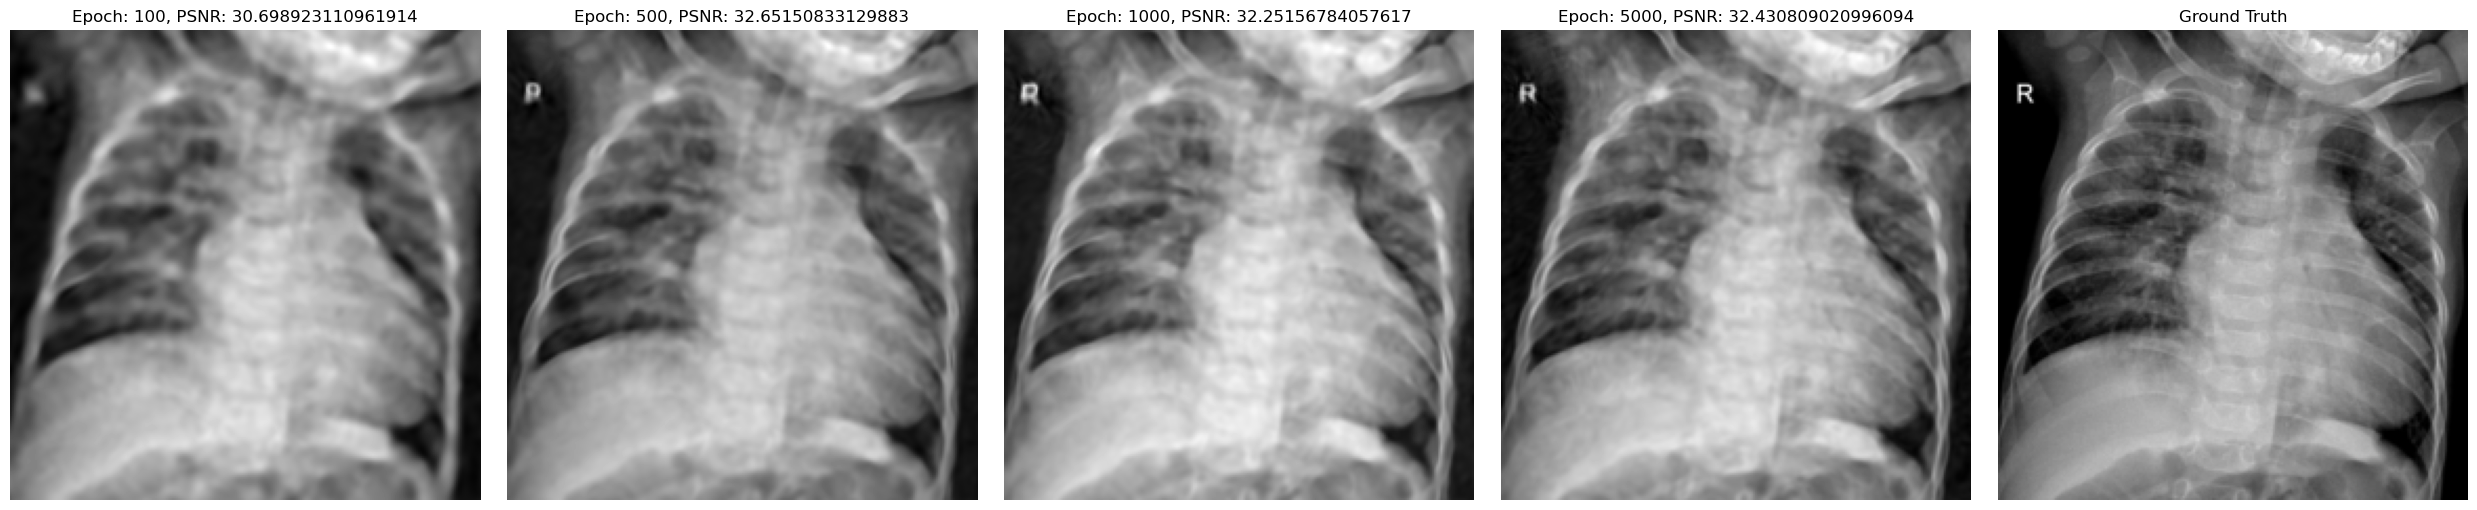

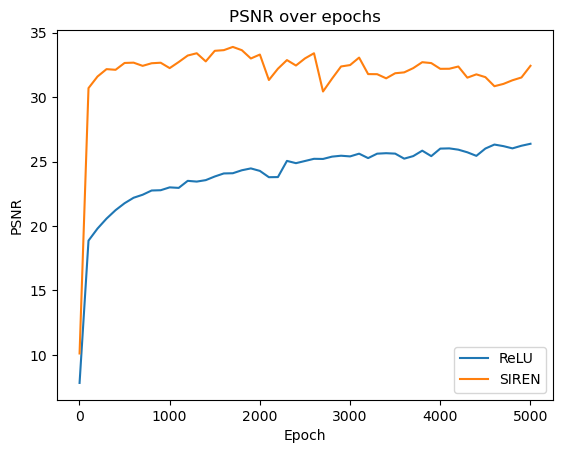

In [14]:
plot_reconstructions(siren_module.progress_ims, gt_image.cpu())
plot_scores([inr_module,
             siren_module])

### WIRE

Another popular choice of activation functions are Wavelet Implicit Neural Representations (WIRE) as proposed by the paper [*WIRE: Wavelet Implicit Neural Representations*](https://vishwa91.github.io/wire). WIRE extends SIRENs by applying a Gaussian window over the sinusoidal activation function. This creates a localized waveform that oscillates within a specific region and decays smoothly outside of it. This localization helps to reduce the global influence of each activation, preventing the ringing artifacts that can occur with purely sinusoidal activations.

<center width="100%" style="padding:25px"><img src="https://vishwa91.github.io/files/wire/wire1.png" width="750px"></center>

The authors discuss useful priors of wavelet activations such as robustness to noise. 
<center width="100%" style="padding:25px"><img src="https://vishwa91.github.io/files/wire/wire_sr.png" width="750px"></center>

These activation functions come with two important hyper-parameters. Similar to our SIREN layers, the $\omega$ parameter determines the frequency of the wavelet. The $\sigma$ parameter determines the width of the wavelet.


In [15]:
WIRE_OMEGA = 20.0
WIRE_SIGMA = 10.0

class WIRELayer(nn.Module):
    """
        Implicit representation with Gabor nonlinearity
        Implementation based on https://github.com/vishwa91/wire
    """
    def __init__(self, in_size, out_size, wire_omega: float = 30.0, wire_sigma: float = 40.0, **kwargs):
        super().__init__()
        self.omega_0 = wire_omega  # Frequency of wavelet
        self.scale_0 = wire_sigma  # Width of wavelet
        self.freqs = nn.Linear(in_size, out_size, bias=True)
        self.scale = nn.Linear(in_size, out_size, bias=True)

    def forward(self, x):
        omega = self.omega_0 * self.freqs(x)
        scale = self.scale(x) * self.scale_0
        x = torch.cos(omega) * torch.exp(-(scale * scale))
        return x

In [16]:
import math

def initialize_wire_weights(network: MLP, omega: float):
    """ See SIREN paper supplement Sec. 1.5 for discussion """
    old_weights = network.layers[1].freqs.weight.clone()
    with torch.no_grad():
        # First layer initialization
        num_input = network.layers[0].freqs.weight.size(-1)
        network.layers[0].freqs.weight.uniform_(-1 / num_input, 1 / num_input)
        network.layers[0].scale.weight.uniform_(-1 / num_input, 1 / num_input)
        # Subsequent layer initialization based on omega parameter
        for layer in network.layers[1:-1]:
            num_input = layer.freqs.weight.size(-1)
            layer.freqs.weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
            layer.scale.weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        # Final linear layer also uses initialization based on omega parameter
        num_input = network.layers[-1].weight.size(-1)
        network.layers[-1].weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        network.layers[-1].weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        
    # Verify that weights did indeed change
    new_weights = network.layers[1].freqs.weight
    assert (old_weights - new_weights).abs().sum() > 0.0

In [17]:
# We use the same MLP class as before, but give it our new SIREN layers
wire_inr = MLP(dataset.coord_size,
               dataset.value_size,
               hidden_size=HIDDEN_SIZE*5//7, # WIRE layers have 2 linear components, try to roughly have the same #params as our other baselines
               num_layers=NUM_LAYERS,
               layer_class=WIRELayer, 
               wire_omega=WIRE_OMEGA,
               wire_sigma=WIRE_SIGMA,
               )
initialize_wire_weights(wire_inr, WIRE_OMEGA)
wire_module = INRLightningModule(network=wire_inr,
                                 gt_im=gt_image,
                                 lr=LEARNING_RATE,
                                 name='WIRE',
                                )
trainer = pl.Trainer(max_epochs=TRAINING_EPOCHS)
s = datetime.now()
trainer.fit(wire_module, train_dataloaders=dataloader)
print(f"Fitting time: {datetime.now()-s}s.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | network | MLP  | 34.1 K
---------------------------------
34.1 K    Trainable params
0         Non-trainable params
34.1 K    Total params
0.137     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Fitting time: 0:02:00.849941s.


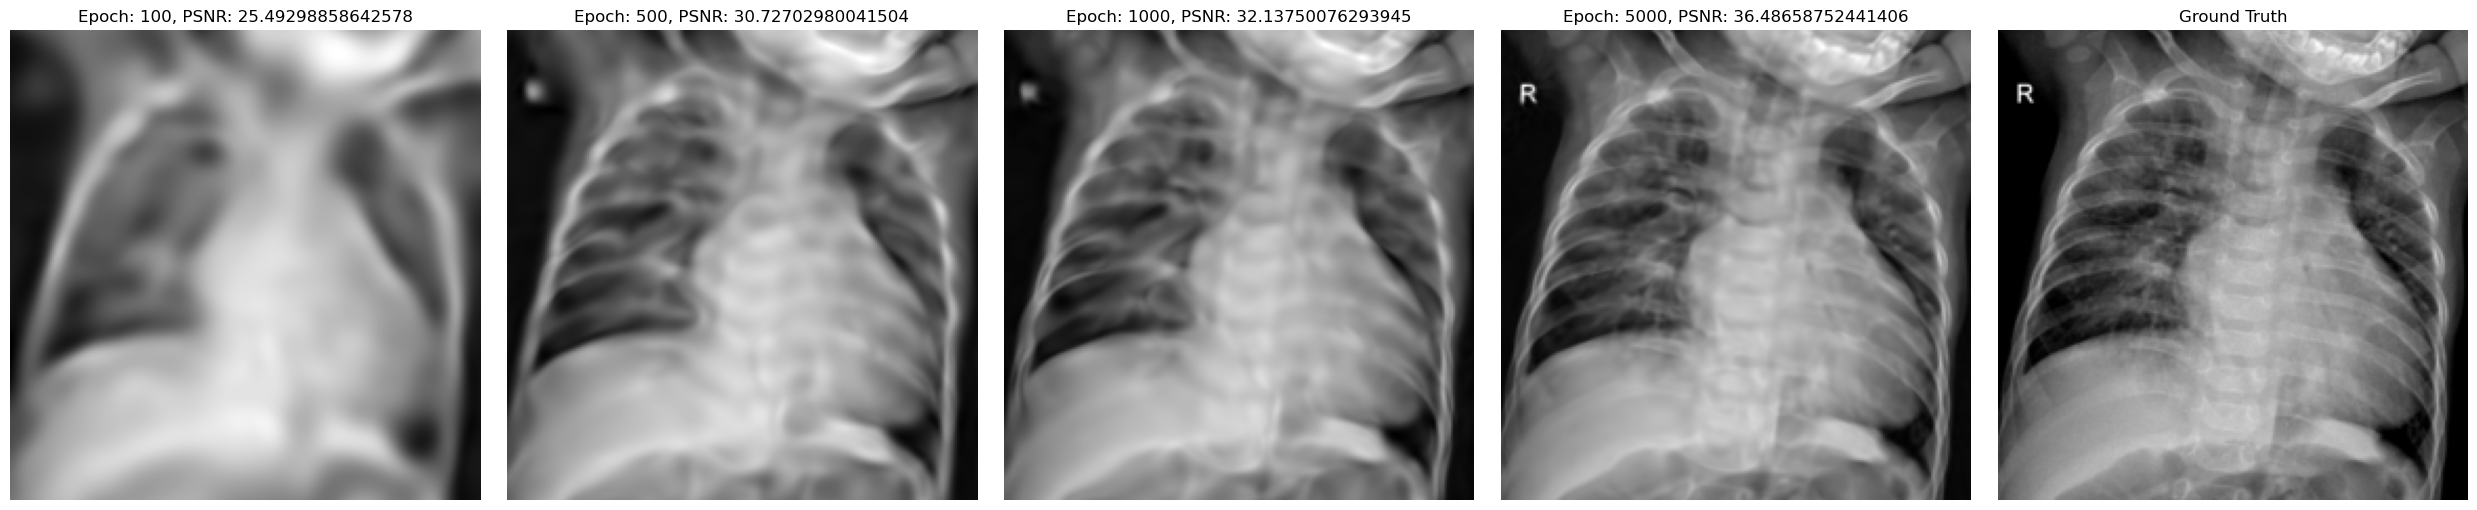

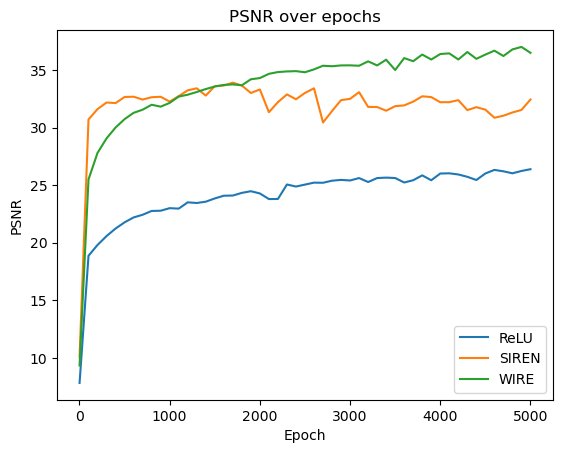

In [18]:
plot_reconstructions(wire_module.progress_ims, gt_image)
plot_scores([inr_module,
             siren_module,
             wire_module])


## Positional Encoders

One simple architectural change is the addition of positional encoders. These are coordinate mappings that help emphasize suddle changes in coordinates to the network.

One popular choice of positional encoder are [Fourier Features](https://bmild.github.io/fourfeat/).


<center width="100%" style="padding:25px"><img src="https://bmild.github.io/fourfeat/img/teaser.png" width="750px"></center>

Fourier feature mappings use a random Gaussian matrix $B$ that map low-dimensional coordinates $v$ to high-dimensional fourier spaces before passing them into the network:

$$
\gamma(\mathbf{v})=[\cos (2 \pi \mathbf{B v}), \sin (2 \pi \mathbf{B v})]^{\mathrm{T}}
$$

The scale of the Gaussian matrix helps us control the amount of underfitting/overfitting on high-frequency details.


<video id="v0" width="100%" autoplay="1" loop="1" muted="" controls="" src="https://bmild.github.io/fourfeat/img/test_sweep_1e-4_5000_more_low.mp4" type="video/mp4"> </video>

Fourier features can be implemented using a few lines of code. They make ReLU INRs achieve perfomance comparable to SIREN or WIRE INRs. 

In [19]:
import torch
from torch import nn

class FourierFeatures(nn.Module):
    """ Positional encoder from Fourite Features [Tancik et al. 2020]
     Implementation based on https://github.com/tancik/fourier-feature-networks/blob/master/Demo.ipynb """
    def __init__(self,
                 coord_size: int,
                 freq_num: int,
                 freq_scale: float = 1.0):
        super().__init__()
        self.freq_num = freq_num  # Number of frequencies
        self.freq_scale = freq_scale  # Standard deviation of the frequencies
        self.B_gauss = torch.normal(0.0, 1.0, size=(coord_size, self.freq_num)) * self.freq_scale

        # We store the output size of the module so that the INR knows what input size to expect
        self.out_size = 2 * self.freq_num

    def forward(self, coords):
        # Map the coordinates to a higher dimensional space using the randomly initialized features
        b_gauss_pi = 2. * torch.pi * self.B_gauss.to(coords.device)
        prod = coords @ b_gauss_pi
        # Pass the features through a sine and cosine function
        out = torch.cat((torch.sin(prod), torch.cos(prod)), dim=-1)
        return out

We reuse our `INRModule` Lightning module from above by adding the additional positional encoder and modifying the `forward()` function.

In [20]:
class PosEncINRLightningModule(INRLightningModule):
    """ INR with Fourier Feature positional encoding """
    def __init__(self,
                 pos_encoder: nn.Module,
                 network: MLP,
                 **kwargs):
        super().__init__(network=network, **kwargs)
        self.pos_encoder = pos_encoder

    def configure_optimizers(self):
        # Note that we do NOT optimize the positional encoder's parameters.
        return torch.optim.Adam(self.network.parameters(), lr=self.lr)

    def forward(self, coords):
        # Apply positional encoding, then apply network
        pos_enc_coords = self.pos_encoder(coords)
        return self.network(pos_enc_coords)


In [21]:
FF_FREQS = 64
FF_SCALE = 1.0

ff_pos_enc = FourierFeatures(dataset.coord_size, freq_num=FF_FREQS, freq_scale=FF_SCALE)
ff_relu_inr = MLP(ff_pos_enc.out_size,
               dataset.value_size,
               hidden_size=HIDDEN_SIZE*3//4,  # try to roughly have the same #params as our other baselines
               num_layers=NUM_LAYERS,
               layer_class=ReLULayer,
               )
ffinr_module = PosEncINRLightningModule(pos_encoder=ff_pos_enc,
                                        network=ff_relu_inr,
                                        name='FF+ReLU',
                                        lr=LEARNING_RATE,
                                        gt_im=gt_image,
                                       )
trainer = pl.Trainer(max_epochs=TRAINING_EPOCHS)
s = datetime.now()
trainer.fit(ffinr_module, train_dataloaders=dataloader)
print(f"Fitting time: {datetime.now()-s}s.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type            | Params
------------------------------------------------
0 | network     | MLP             | 31.1 K
1 | pos_encoder | FourierFeatures | 0     
------------------------------------------------
31.1 K    Trainable params
0         Non-trainable params
31.1 K    Total params
0.124     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Fitting time: 0:01:34.091484s.


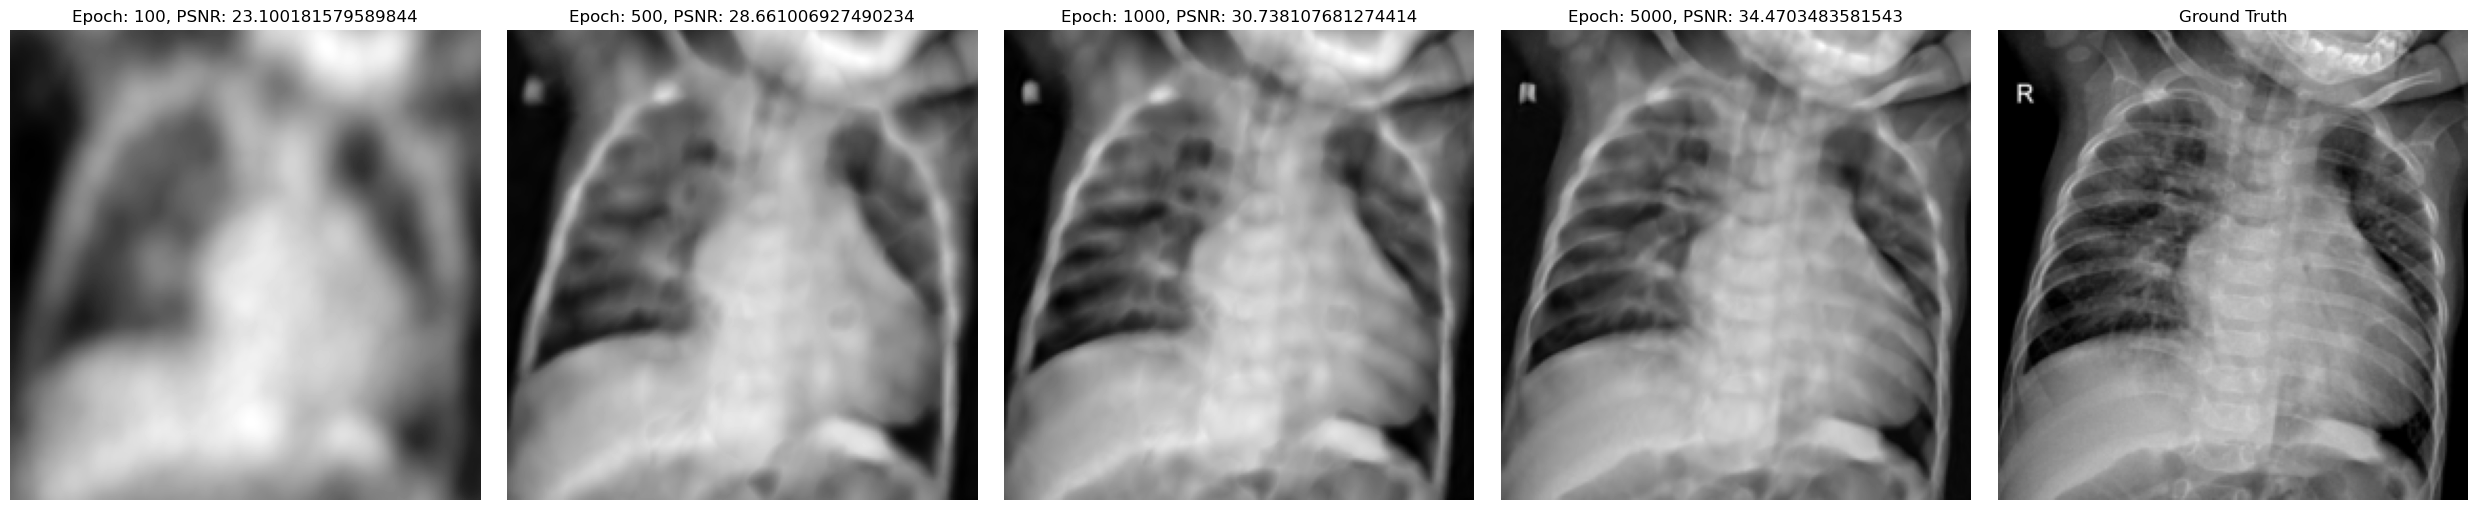

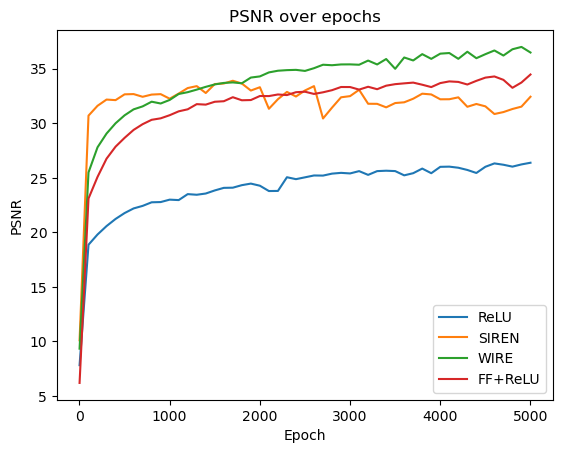

In [22]:
plot_reconstructions(ffinr_module.progress_ims, gt_image)
plot_scores([inr_module,
             siren_module,
             wire_module,
             ffinr_module])

# INRs for interpolation

One application of INRs is data interpolation. Once the INR is trained, we can resample the image at any arbitrary coordinates we want. So far we've been applying our INR to a simple 2D image, however plenty of simpler interpolation algorithms already exist that can be applied to grids.

INRs shine in modalities with non-standard or unstructured data. In medical imaging there are lots of domains with non-standard sampling strategies. Many medical imaging tools provide well-calibrated coordinate system along-side the image information, which often go unused by deep learning models.

This makes INRs specially well-suited for many medical imaging tasks, as once trained on a coordinate system, they provide the ability to resample an image at any coordinates we want.

One such example of a domain is magnetic resonance imaging (MRI). MRI data is sampled in the frequency domain (otherwise known as K-space). A Fourier transform is then performed to reconstruct the image from the spatial frequency data. (The following images are borrowed from [mri.questions.com](https://mriquestions.com/), which offers a great introduction to MRI and the underlying physics.)

<center width="100%" style="padding:25px"><img src="https://s.mriquestions.com/uploads/3/4/5/7/34572113/4956435.jpg?597" width="550px"></center>

In order to perform the Fourier transform, our K-space data needs to be in a Cartesian grid (as seen in yellow). However, not all sampling patterns follow a regular grid. One such example is *radial sampling*, as seen in pink.

<table style="width: 100%; border-collapse: collapse;">
  <tr>
    <td style="width: 50%; text-align: center; padding: 10px;">
      <img src="https://mriquestions.com/uploads/3/4/5/7/34572113/editor/kspace-cartesian.gif?1501763922" width="250" alt="Cartesian sampling of k-space">
      <br>
      <span style="display: inline-block; font-size: 90%; margin-top: 10px;">Cartesian sampling of <i>k</i>-space</span>
    </td>
    <td style="width: 50%; text-align: center; padding: 10px;">
      <img src="https://mriquestions.com/uploads/3/4/5/7/34572113/kspace-radial-filling_orig.gif" width="250" alt="Radial sampling of k-space">
      <br>
      <span style="display: inline-block; font-size: 90%; margin-top: 10px;">Radial sampling of <i>k</i>-space</span>
    </td>
  </tr>
</table>


Radial sampling acquires K-space lines in a rotating fashion about the center of the space. These radial lines are called _spokes_. A downside of radial sampling is having to interpolate our samples into a grid in order to perform the Fourier transform. 

Furthermore, a common practice in MRI is to accelerate the acquisition process by purposely undesampling the K-space. This comes at the cost of having to further interpolate our K-space, which introduces noise into our reconstruction. 

In this section we will reproduce [a 2023 paper by W. Huang](https://arxiv.org/pdf/2212.08479), which makes use of INRs to interpolate undersampled radial K-space data. In their paper, they apply an INR to a 2D+time cardiac data, showing that:
- INRs have stronger priors than traditional interpolation techniques.
- INRs can produce clear reconstructions in a **single-subject** training setting (as opposed to dataset-based approaches in typical deep learning approaches).

<center width="100%" style="padding:25px"><img src="https://media.springernature.com/full/springer-static/image/chp%3A10.1007%2F978-3-031-34048-2_42/MediaObjects/538831_1_En_42_Fig1_HTML.png?as=webp" width="550px"></center>


## Data preparation
We will begin by downloading and preprocessing a K-space dataset for a single subject from the Harvard Medical School's [Cardiac MR Center Dataverse](https://dataverse.harvard.edu/dataverse/cardiacmr).

In [23]:
import os

current_dir = os.getcwd()
download_dir = os.path.join(current_dir, 'data_download')
os.makedirs(download_dir, exist_ok=True)
file_name = os.path.join(download_dir, 'radial_dataset.mat')


In [24]:
# We'll try to download using a headless Chrome browser.
# If this doesn't work, you should manually copy and paste the url to your 
# browser to start the download, then copy the file to the file_name location listed above.

url = r'https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/CI3WB6/XS8ZVS'

if not os.path.exists(file_name):
    from selenium import webdriver
    from selenium.webdriver.chrome.options import Options
    import time
    
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_experimental_option("prefs", {
        "download.default_directory": download_dir,
        "download.prompt_for_download": False,
        "download.directory_upgrade": True,
        "safebrowsing.enabled": False
    })
    
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)
    
    time.sleep(5)
    download_path = os.path.join(download_dir, os.listdir(download_dir)[-1])
    
    def wait_for_download(file_path, timeout=120, expected_size='233320724'):
        """Wait for the file to be downloaded completely."""
        end_time = time.time() + timeout
        while time.time() < end_time:
            print(f'File size: {os.path.getsize(file_path)} / 233320724', end='\r')
            if int(os.path.getsize(file_path)) == int(expected_size):
                return True
            time.sleep(1)
        return False
        
    # Wait for the download to complete
    print("Downloading to:", download_dir)
    if wait_for_download(download_path):
        os.rename(download_path, file_name)
        assert os.path.getsize(file_name) > 0
        print(f"File downloaded successfully to {file_name}")
    else:
        print("File download failed or timed out")
    
    driver.quit()

Next, let's load the data from its `.map` file and preprocess it.   
The data comes in a 4-dimensional array. Appart from height and width dimensions, we have time and coil dimensions. It is these 2 extra dimensions we hope our network will take advantage of to improve interpolation results.

In [25]:
import scipy.io as sio
import numpy as np
import torch

mat_file = sio.loadmat(file_name)
full_kdata = mat_file['data'].astype(np.float32)
full_kdata = torch.from_numpy(full_kdata)

# The data is a multi-coil 2D+time slice with the following dimensions:
print(full_kdata.shape)
# (#slices, #frames, #samples_per_spoke, #spokes, #coils, real_and_imaginary_components)

# The data contains a lot of padding, let's remove it to save memory
spoke_length = full_kdata.shape[2]
single_spoke = full_kdata[0,0,:,0,0,0]
pad_end = torch.sum(single_spoke[:spoke_length//2] == 0)
full_kdata = full_kdata[:, :, pad_end:-pad_end]

# Get rid of batch dimension, convert to complex, and move spatial dimensions to the end
full_kdata = full_kdata.squeeze(0)
full_kdata = full_kdata[...,0] + 1j*full_kdata[...,1]  # convert to complex
full_kdata = torch.permute(full_kdata, (0, 2, 1, 3))  # (nphases, nspokes, spoke_len, ncoil)
print("Full data shape:", full_kdata.shape)
# Each of the 25 time frames has 16 coil images, and each coil image has 832*196 samples 
print("Number of frames:", full_kdata.shape[0])
print("Number of spokes:", full_kdata.shape[1])
print("Number of samples per spoke:", full_kdata.shape[2])
print("Number of coils:", full_kdata.shape[3])


torch.Size([1, 25, 832, 196, 16, 2])
Full data shape: torch.Size([25, 196, 240, 16])
Number of frames: 25
Number of spokes: 196
Number of samples per spoke: 240
Number of coils: 16


In [26]:
# Let's generate the coordinates for each of our samples in our spokes
def generate_sample_coordinates(kdata_arr):
    nphases, nspokes, spoke_len, _ = kdata_arr.shape
    # Calculate the angle of each spoke (in rad)
    # spoke_angles = np.linspace(0, np.pi, nspokes, endpoint=False)   # not 2pi because the trajectory is symmetric
    spoke_angles = torch.linspace(0, np.pi, nspokes)   # not 2pi because the trajectory is symmetric
    
    # calculate the k-space coordinates of each point in each spoke
    unit_vectors = torch.stack([torch.cos(spoke_angles), torch.sin(spoke_angles)], axis=-1)  # (nspokes, 2)
    # distance_to_center = torch.linspace(-1, 1, spoke_len, endpoint=False)    # (spoke_len,)
    distance_to_center = torch.linspace(-1, 1, spoke_len)    # (spoke_len,)
    traj = unit_vectors[:,None] * distance_to_center[None,:,None]  # (nspokes, spoke_len, 2)
    
    # repeat the trajectory for each frame
    traj = traj[None,...].repeat((nphases, 1, 1, 1))  # (frames, nspokes, spoke_len, 2)
    return traj

full_ktraj = generate_sample_coordinates(full_kdata)

# Coordinates are shared across each coil.
# Our coordinate shape is thus: (#frames, #spokes, #spoke_len, #xy_coordinates)
print("Coordinates shape:", full_ktraj.shape)

Coordinates shape: torch.Size([25, 196, 240, 2])


## Interpolation using NU-IFFT
In order to perform the inverse fourier transform, our radially sampled data needs to first be interpolated into a Cartesian grid. This is the first process performed by the _non-uniform inverse fast Fourier transform_ (NU-IFFT) algorithm.

Let's interpolate our K-space into a Cartesian grid. 

In [27]:
# To visualize K-space, we need to interpolate into a Cartesian grid
# We'll use the torchkbnufft library, which allows us to use a GPU
import torchkbnufft as tkbn 
import torch

def visualize_cartesian_magnitude(kdata_arr: torch.Tensor, ktraj_arr: torch.Tensor):
    """ This function interpolates our k-space samples into a cartesian grid.
        Then, it combines all coil channels and returns only the magnitude of the k-space. 
    """
    nphases, nspokes, spoke_len, ncoils = kdata_arr.shape
    # Create the forward Interp object
    interp_adj = tkbn.KbInterpAdjoint((spoke_len, spoke_len), (spoke_len, spoke_len))

    # the trajectory is in radians, for torchkbnufft, it should be in the range of [-pi, pi]
    ktraj_arr = ktraj_arr.to(torch.float32) * np.pi  
    print("K-space values shape:", kdata_arr.shape, "Coordinates shape:", ktraj_arr.shape)

    # torchkbufft doesn't care about the nspoke dimension, so we can just flatten it
    kdata_arr = kdata_arr.moveaxis(-1, 1).reshape(nphases, ncoils, spoke_len*nspokes)  # (nphases, ncoils, spoke_len*nspokes)
    ktraj_arr = ktraj_arr.moveaxis(-1, 1).reshape(nphases, 2, spoke_len*nspokes)   # (nphases, 2, spoke_len*nspokes)
    
    # move to GPU if available
    if torch.cuda.is_available():
        kdata_arr = kdata_arr.cuda()
        ktraj_arr = ktraj_arr.cuda()
        interp_adj = interp_adj.cuda()
    
    # calculate the density compensation. This is very slow... and inaccurate...
    dcf = tkbn.calc_density_compensation_function(ktraj_arr, im_size=(spoke_len, spoke_len), num_iterations=10)    
    weighted_kdata = kdata_arr * dcf

    # Avoid batch-wise nufft to reduce memory footprint
    coil_kspace = torch.zeros((nphases, spoke_len, spoke_len, ncoils), dtype=kdata_arr.dtype, device=kdata_arr.device)
    for i in range(nphases):
        coil_kspace[i:i+1] = interp_adj(weighted_kdata[i:i+1], ktraj_arr[i:i+1]).moveaxis(1, -1)
    coil_kspace = torch.fft.ifftshift(coil_kspace, axis=(-3, -2))  # Shift low-freqs to center
    # coil_kspace = coil_kspace.moveaxis(1, -1)  # (nphases, spoke_len*nspokes, ncoils)
    return coil_kspace.cpu()

full_kdata_cart = visualize_cartesian_magnitude(full_kdata, full_ktraj)
print("Interpolated k-space shape:", full_kdata_cart.shape, full_kdata_cart.dtype)


K-space values shape: torch.Size([25, 196, 240, 16]) Coordinates shape: torch.Size([25, 196, 240, 2])
Interpolated k-space shape: torch.Size([25, 240, 240, 16]) torch.complex64


Let us visualize what our frequency samples look like:

In [28]:
# Helper functions
def combine_coils(arr):
    """ Combine coils with root sum of squares. """
    real_arr = torch.abs(arr)  # complex -> real
    return torch.sqrt(torch.sum(real_arr**2, dim=-1))


def kspace_to_image(freqs):
    """ Perform an inverse fast Fourier Transform """
    # return torch.fft.ifft2(torch.fft.ifftshift(freqs, axis=(-2, -1)))
    # return torch.fft.ifftshift(torch.fft.ifft2(freqs), axis=(-2, -1))
    return torch.fft.fftshift(torch.fft.ifft2(torch.fft.fftshift(freqs, axis=(-3, -2)), axis=(-3, -2)), axis=(-3, -2))


In [29]:
import imageio
from IPython.display import Image, display
from io import BytesIO

def display_array_as_gif(im: torch.Tensor, max_norm=None, width=400):
    if max_norm is not None:
        im = im / max_norm
    im = im.clamp(0.0, 1.0)
    im = im.cpu().numpy()
    # Convert frames to uint8 and scale to 0-255
    frames = [(im[frame] * 255).astype(np.uint8) for frame in range(im.shape[0])]
    
    bio = BytesIO()
    # Create a GIF in memory
    with imageio.get_writer(bio, format='gif', fps=12, loop=0) as writer:
        for frame in frames:
            writer.append_data(frame)
    bio.seek(0)
    # Display the GIF
    display(Image(data=bio.getvalue(), format='gif', width=width))


Ground-truth k-space


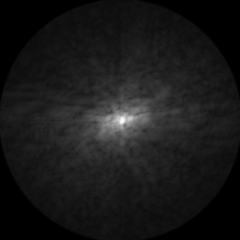

In [30]:
print("Ground-truth k-space")
full_kspace_vis = combine_coils(full_kdata_cart)
full_kspace_vis_sqrt = torch.sqrt(full_kspace_vis)  # Scale low-frequencies (just for visualization purposes)
# Display resulting image as a gif
max_full_k_value = full_kspace_vis_sqrt.amax()
display_array_as_gif(full_kspace_vis_sqrt, max_norm=max_full_k_value, width=400)

What you see here are the spatial frequencies of our image.   
As a human, it is very hard to figure out what is going on just by looking at it. So let's now visualize what our image really looks like!   
Let's make a function to perform an inverse Fourier transform. This will let us convert our interpolated cartesian frequency data into an image.

Image reconstruction using NU-IFFT
torch.Size([25, 240, 240, 16]) torch.complex64


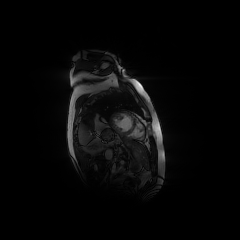

In [31]:
print("Image reconstruction using NU-IFFT")
print(full_kdata_cart.shape, full_kdata_cart.dtype)
full_img = kspace_to_image(full_kdata_cart)
full_img = torch.fft.ifftshift(full_img)
full_img_vis = combine_coils(full_img)
max_full_img_value = full_img_vis.amax()
display_array_as_gif(full_img_vis, max_norm=max_full_img_value, width=400)

In practice, accelerated images don't look so good. This is because the k-space is undersampled and we have missing information. When less spokes are available, reconstruction artifacts become apparent on our reconstructed images.   
Let's simulate an undersampling of our K-space samples by leaving out some spokes each frame.

In [32]:
# Next, let's simulate an undersampling of the data
UNDERSAMPLE_RATIO = 4

nspokes = full_kdata.shape[1] // UNDERSAMPLE_RATIO
us_kdata = torch.zeros((full_kdata.shape[0], nspokes, full_kdata.shape[2], full_kdata.shape[3]), dtype=full_kdata.dtype)
us_ktraj = torch.zeros((full_ktraj.shape[0], nspokes, full_ktraj.shape[2], full_ktraj.shape[3]), dtype=full_ktraj.dtype)
for frame in range(full_kdata.shape[0]):
    # skip spokes to simulate undersampling
    us_kdata[frame] = full_kdata[frame, frame % UNDERSAMPLE_RATIO::UNDERSAMPLE_RATIO][:nspokes] 
    us_ktraj[frame] = full_ktraj[frame, frame % UNDERSAMPLE_RATIO::UNDERSAMPLE_RATIO][:nspokes] 
print("Undersampled data shape:", us_kdata.shape)
# Each of the 25 time frames has 16 coil images, and each coil image has 832*196 samples 
print("Number of frames:", us_kdata.shape[0])
print("Number of spokes:", us_kdata.shape[1])
print("Number of samples per spoke:", us_kdata.shape[2])
print("Number of coils:", us_kdata.shape[3])

Undersampled data shape: torch.Size([25, 49, 240, 16])
Number of frames: 25
Number of spokes: 49
Number of samples per spoke: 240
Number of coils: 16


Let's see what an undersampled reconstruction looks like:

In [33]:
us_kdata_cart = visualize_cartesian_magnitude(us_kdata, us_ktraj)
us_img = kspace_to_image(us_kdata_cart)

K-space values shape: torch.Size([25, 49, 240, 16]) Coordinates shape: torch.Size([25, 49, 240, 2])


Undersampled k-space


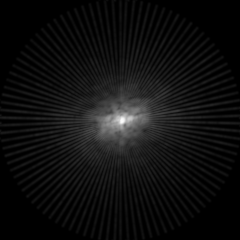

Undersampled image reconstruction using NU-IFFT


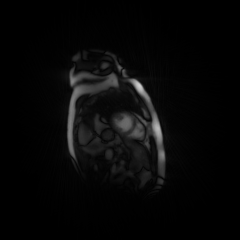

Error between GT and NU-IFFT reconstruction


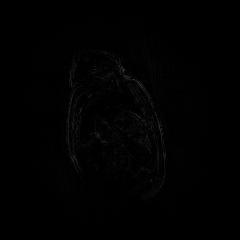

In [34]:
print("Undersampled k-space")
us_kspace_vis = combine_coils(us_kdata_cart)  # Combine coils with root sum of squares
us_kspace_vis = torch.sqrt(us_kspace_vis)  # Scale low-frequencies for visualization purposes
display_array_as_gif(us_kspace_vis, max_norm=max_full_k_value, width=400)

print("Undersampled image reconstruction using NU-IFFT")
us_img_vis = combine_coils(us_img)  # Combine coils with root sum of squares
us_img_vis = torch.fft.ifftshift(us_img_vis)
display_array_as_gif(us_img_vis, max_norm=max_full_img_value, width=400)

print("Error between GT and NU-IFFT reconstruction")
error_im = (us_img_vis - full_img_vis).abs()
display_array_as_gif(error_im, max_norm=max_full_img_value, width=400)

Notice the general blurriness across the image.
By removing spokes from our k-space, our outer regions (high-frequencies) are less sampled relative to our center regions (low-frequencies), thus our undersampled image has lost its 'sharpness'.  

Notice also the line-like artifacts in the background. Since our naive interpolation applies zero-filling as our 'prior' for non-sampled areas, we don't know how to maintain a smooth background.

## Interpolation using an INR
Now, let's try to train an INR directly on the sparse K-space samples. 

An issue with the naive NU-IFFT is that the time dimension is completely ignored. Each frame is interpolated independently. However, our network will have access to the time component of the coordinate, allowing it to have an understanding of how neighbouring points relate temporally.

First, let's create our dataset.

In [35]:
import torch
from torch.utils.data import Dataset, DataLoader

POINTS_PER_SAMPLE = 240**2

class RadialDataset(Dataset):
    def __init__(self, image: torch.Tensor, coordinates: torch.Tensor, points_num: int = POINTS_PER_SAMPLE):
        super().__init__()
        assert image.dtype == torch.complex64, image.dtype
        assert coordinates.dtype == torch.float32, coordinates.dtype
        assert image.shape[:-1] == coordinates.shape[:-1]
        self.device = "cpu"
        self.points_num = points_num
        self.image = image.to(self.device)  # (Time, Coils, Spokes, Spoke_length)
        self.coordinates = coordinates.to(self.device)  # (Time, Spokes, Spoke_length, 2)
        self.dim_sizes = self.coordinates.shape[:-1]  # Size of each dimension

        # To help us define the input/output sizes of our network later
        # we store the size of our input coordinates and output values
        self.coord_size = len(self.coordinates.shape[:-1])
        self.value_size = image.shape[-1] 

    def __len__(self):
        return 1

    def __getitem__(self, idx: int):
        # Create random sample of indices
        point_indices = [torch.randint(0, i, (self.points_num,), device=self.device) for i in self.dim_sizes]

        # Retrieve k-space values from selected indices
        point_values = self.image[tuple(point_indices)]
        # point_values = torch.view_as_real(point_values)  # We represent real and imaginary value separately
        point_values_ = point_values.reshape(-1, self.value_size)

        # Convert time and coil coord in [0.0, 1.0] range
        time_coord = point_indices[0] / (self.dim_sizes[0] - 1) * 2 - 1
        # x and y coords are already normalized
        xy_coords = self.coordinates[(point_indices[0], point_indices[1], point_indices[2])]

        point_coords_norm = torch.cat((time_coord[:, None], xy_coords), dim=-1)

        # The subject index is also returned in case the user wants to use subject-wise learned latents
        return point_coords_norm, point_values

radial_dataset = RadialDataset(us_kdata, us_ktraj, points_num=POINTS_PER_SAMPLE)
example_batch = radial_dataset[0]
print("Coordinate sample shape:", example_batch[0].shape)
print("Value sample shape:", example_batch[1].shape)
print("Value sample data type:", example_batch[1].dtype)

# We set a batch_size of 1 since our dataset is already returning a batch of points.
radial_dataloader = DataLoader(radial_dataset, batch_size=1, num_workers=0, pin_memory=True)

Coordinate sample shape: torch.Size([57600, 3])
Value sample shape: torch.Size([57600, 16])
Value sample data type: torch.complex64


Let's create some plotting functions similar to the first section of the tutorial.   
We'll measure image sharpness with the normalized cross-correlation (NCC) metric.

In [36]:
from typing import Tuple, List, Optional
import matplotlib.pyplot as plt

# We will track visual results every few epochs and visualize them after training
def plot_reconstructions(progress_ims: List[Tuple[int, torch.Tensor]], gt_im: torch.Tensor):
    ncols = len(progress_ims) + 1
    fig_width = 5
    fig, axs = plt.subplots(ncols=ncols, figsize=(ncols*fig_width, fig_width))
    # Plot all reconstructions images predicted by the model
    for i, (epoch, im, metric) in enumerate(progress_ims):
        im = im.cpu().numpy()
        ax = axs[i]
        ax.imshow(im, cmap='gray')
        ax.axis('off')
        title = f'Epoch: {epoch}, NCC: {metric}'
        ax.set_title(title)
    # PLot ground-truth image
    gt_im = gt_im.cpu().numpy()
    axs[-1].imshow(gt_im, cmap='gray')
    axs[-1].axis('off')
    axs[-1].set_title('Ground Truth')
    plt.tight_layout()
    plt.show()

# We will also track the NCC of our training samples
def ncc(template: torch.Tensor, image: torch.Tensor):
    # Compute means and standard deviatons
    template_mean = template.mean()
    image_mean = image.mean()
    template_std = template.std()
    image_std = image.std()
    
    # Compute correlation and normalize
    correlation = ((template - template_mean) * (image - image_mean)).mean()
    ncc = correlation / (template_std * image_std)
    return ncc

# Let's create a function to plot our psnr scores throughout training
def plot_scores(models: List['INRModule']):
    fig, ax = plt.subplots()
    # For each model, plot list of scores
    for model in models:
        epochs, scores = [i for i, _ in model.scores], [v for _, v in model.scores]
        ax.plot(epochs, scores, label=model.name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.set_title('Normalized cross-correlation over epochs')
    ax.legend()
    plt.show()

While the original paper uses FF+ReLU, WIRE seemed to be the most robust in our experiments and consistently gave us a better performance. However, feel free to experiment yourself with whichever architecture you'd like!   
We'll redefine WIRE layers again here so this section can be ran independently of the first tutorial section.

In [37]:
import math
import torch
from torch import nn

WIRE_OMEGA = 20.0
WIRE_SIGMA = 10.0

class WIRELayer(nn.Module):
    """
        Implicit representation with Gabor nonlinearity
        Implementation based on https://github.com/vishwa91/wire
    """
    def __init__(self, in_size, out_size, wire_omega: float = 30.0, wire_sigma: float = 40.0, **kwargs):
        super().__init__()
        self.omega_0 = wire_omega  # Frequency of wavelet
        self.scale_0 = wire_sigma  # Width of wavelet
        self.freqs = nn.Linear(in_size, out_size, bias=True)
        self.scale = nn.Linear(in_size, out_size, bias=True)

    def forward(self, x):
        omega = self.omega_0 * self.freqs(x)
        scale = self.scale(x) * self.scale_0
        x = torch.cos(omega) * torch.exp(-(scale * scale))
        return x

class MLP(nn.Module):
    def __init__(self,
                 in_size: int,
                 out_size: int,
                 hidden_size: int = 128,
                 num_layers: int = 3,
                 layer_class: nn.Module = WIRELayer,
                 **kwargs):
        super().__init__()

        a = [layer_class(in_size, hidden_size, **kwargs)]
        for i in range(num_layers - 1):
            a.append(layer_class(hidden_size, hidden_size, **kwargs))
        a.append(nn.Linear(hidden_size, out_size))
        self.layers = nn.ModuleList(a)        

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x


def initialize_wire_weights(network: MLP, omega: float):
    """ See SIREN paper supplement Sec. 1.5 for discussion """
    old_weights = network.layers[1].freqs.weight.clone()
    with torch.no_grad():
        # First layer initialization
        num_input = network.layers[0].freqs.weight.size(-1)
        network.layers[0].freqs.weight.uniform_(-1 / num_input, 1 / num_input)
        network.layers[0].scale.weight.uniform_(-1 / num_input, 1 / num_input)
        # Subsequent layer initialization based on omega parameter
        for layer in network.layers[1:-1]:
            num_input = layer.freqs.weight.size(-1)
            layer.freqs.weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
            layer.scale.weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        # Final linear layer also uses initialization based on omega parameter
        num_input = network.layers[-1].weight.size(-1)
        network.layers[-1].weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        network.layers[-1].weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        
    # Verify that weights did indeed change
    new_weights = network.layers[1].freqs.weight
    assert (old_weights - new_weights).abs().sum() > 0.0

And finally, let's define our pytorch lightning module for training

In [38]:
import torch
from torch import nn
import lightning as pl

class KINRLightningModule(pl.LightningModule):
    def __init__(self,
                 network: MLP,
                 gt_im: torch.Tensor,
                 lr: float = 0.001,
                 name: str = "",
                 eval_interval: int = 1000,
                 visualization_intervals: List[int] = [0, 1000, 10000, 50000, 100000],
                ):
        super().__init__()
        self.lr = lr
        self.network = network

        # Logging
        self.name = name
        self.gt_im = gt_im
        self.eval_interval = eval_interval
        self.visualization_intervals = visualization_intervals
        self.progress_ims = []
        self.progress_ks = []
        self.scores = []

    def configure_optimizers(self):
        return torch.optim.Adam(self.network.parameters(), lr=self.lr)

    def forward(self, coords):
        out = self.network(coords)
        # Convert to complex
        out = out.reshape(coords.shape[0], -1, 2)
        out = torch.view_as_complex(out)
        return out

    def training_step(self, batch, batch_idx):
        coords, values = batch
        coords = coords.view(-1, coords.shape[-1])
        values = values.view(-1, values.shape[-1])
        outputs = self.forward(coords)
        loss = nn.functional.mse_loss(torch.view_as_real(outputs), torch.view_as_real(values)).mean()
        return loss
    
    def on_train_epoch_end(self):
        """ At each visualization interval, reconstruct the image using our INR """
        if (self.current_epoch + 1) % self.eval_interval == 0 or self.current_epoch == 0:
            # Resample image in cartesian grid and apply inverse Fourier Transform
            pred_k = self.sample_cartesian(self.gt_im.shape)
            pred_im = kspace_to_image(pred_k)
            # Merge coils and compute metric of resulting image
            pred_im_vis = combine_coils(pred_im)
            gt_im_vis = combine_coils(self.gt_im.to(pred_im.device))
            metric_value = ncc(pred_im_vis, gt_im_vis).cpu().item()
            self.scores.append((self.current_epoch + 1, metric_value))  # Log metric
            
            # Once in a while, log the first image in the sequence for visualization
            if self.current_epoch + 1 in self.visualization_intervals:
                self.progress_ims.append((self.current_epoch + 1, pred_im_vis.cpu()[0], metric_value))
                pred_k_vis = combine_coils(pred_k)
                self.progress_ks.append((self.current_epoch + 1, pred_k_vis.cpu()[0], metric_value))
            
    @torch.no_grad()
    def sample_cartesian(self, resolution: Tuple[int, ...]):
        """ Evaluate our INR on a grid of coordinates in order to obtain an image. """
        T, H, W, C = resolution  # Dimensions: (Time, Height, Width, Coils)
        # Create coordinate grid
        coords = torch.meshgrid([torch.arange(0, T, device=self.device), 
                                 torch.arange(0, H, device=self.device),
                                 torch.arange(0, W, device=self.device)], indexing='ij')
        coords = torch.stack(coords, dim=-1)
        coords_norm = coords / (torch.tensor((T, H, W), device=self.device) - 1) * 2 - 1  # Normalize to [-1.0, 1.0]

        # Coordinates outside the 1.0 radius will be set two zero (because we don't have training data for those areas)
        zero_mask = coords_norm[0, ..., -2:].pow(2).sum(-1) > 1.0

        # Predict each frame to avoid memory issues
        predictions = torch.zeros((T, H, W, C), dtype=torch.complex64, device=self.device)
        for frame in range(T):
            coords_norm_ = coords_norm[frame].reshape(-1, 3)
            preds_ = self.forward(coords_norm_)
            preds = preds_.reshape((H, W, C))
            preds[zero_mask] = 0.0
            predictions[frame] = preds
        return predictions


In [39]:
WIRE_OMEGA = 20.0             # WIRE frequency parameter
WIRE_SIGMA = 10.0             # WIRE scale parameter
HIDDEN_SIZE = 256             # MLP layer width
NUM_LAYERS = 3                # MLP number of hidden layers
LEARNING_RATE = 1e-4
TRAINING_EPOCHS = 200_000

# We're going to predicting real and imaginary compenents separately for each coil
value_size = 2 * radial_dataset.value_size  
inr = MLP(radial_dataset.coord_size, value_size, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, 
          layer_class=WIRELayer, 
          wire_omega=WIRE_OMEGA,
          wire_sigma=WIRE_SIGMA)
initialize_wire_weights(inr, WIRE_OMEGA)

print("GT image shape:", full_img.shape)
inr_module = KINRLightningModule(network=inr, 
                                 gt_im=full_img, 
                                 lr=LEARNING_RATE,
                                 name="WIRE",
                                 eval_interval=1000,
                                 visualization_intervals=[0, 1000, 5000, 10_000, 50_000, 100_000, 150_000, 200_000],
                                )

GT image shape: torch.Size([25, 240, 240, 16])


In [ ]:
from datetime import datetime

trainer = pl.Trainer(max_epochs=TRAINING_EPOCHS)
s = datetime.now()
trainer.fit(inr_module, train_dataloaders=radial_dataloader)
print(f"Fitting time: {datetime.now()-s}s.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | network | MLP  | 273 K 
---------------------------------
273 K     Trainable params
0         Non-trainable params
273 K     Total params
1.094     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Note that this time around, our performance will not keep getting better forever. This is because, unlike in the first part of the tutorial where we evaluated on the same coordinate we trained on, we are now evaluating on Cartesian grid which contains coordinates the network has never seen before. The network eventually overfits on the training data.

In [ ]:
print("K-space progression during training:")
# Take sqrt to make high-frequency regions more visible  (just for visualization)
progress_ks_sqrt = [(i, np.sqrt(j), v) for i, j, v in inr_module.progress_ks]   
gt_kspace_sqrt = full_kspace_vis[0]
plot_reconstructions(progress_ks_sqrt, gt_kspace_sqrt)

print("Image reconstruction progression during training:")
plot_reconstructions(inr_module.progress_ims, full_img_vis[0])  # Visualize only first frame

# Plot training PSNR scores
plot_scores([inr_module])

Let's visualize our INR's predicted k-space alongside the previous naively-interpolated one.

In [ ]:
# Let's visualize our k-space and compare it to naive interpolation
inr_module = inr_module.cuda()
inr_k = inr_module.sample_cartesian(inr_module.gt_im.shape).cpu()      # Use our network to predict our interpolated k-space
inr_k_vis = combine_coils(inr_k)
us_k_vis = combine_coils(us_kdata_cart)                                    # Undersampled k-space interpolated using NU-IFFT
full_k_vis = combine_coils(full_kdata_cart)                                # GT k-space interpolated using NU-IFFT

# Let's visualize our INR k-space along-size the undersampled and fully-sampled NU-IFFT k-spaces
k_vis = torch.concatenate((inr_k_vis.sqrt(),
                           us_k_vis.sqrt(),            # Plot the square root to make high-frequency regions more visible
                           full_k_vis.sqrt()), dim=2)  # Concat along the width dimension (for visualizing horizontally)
print("Undersampled k-space interpolated using INR          Undersampled k-space interpolated using NU-IFFT              Fully-sampled k-space ")
max_full_k_value = full_k_vis.sqrt().amax()
display_array_as_gif(k_vis, max_norm=max_full_k_value, width=400*3)

Let's now see apply the inverse Fourier transform and visualize our image. Let's put it side-by-side with the undersampled NU-IFFT version and the full-sampled GT image.

In [ ]:
# Let's visualize the reconstructed images of these k-spaces
inr_im = combine_coils(kspace_to_image(inr_k))                                   # Reconstruct image from our predicted k-space 
us_im = combine_coils(torch.fft.ifftshift(kspace_to_image(us_kdata_cart)))       # Reconstruct image of the undersampled k-space
full_im = combine_coils(torch.fft.ifftshift(kspace_to_image(full_kdata_cart)))   # Reconstruct image of the fully-sapmled k-space
print("Undersampled image reconstruction using INR            Undersampled image reconstruction using NU-IFFT         Fully-sampled image reconstruction ")
im_vis = torch.concatenate((inr_im, us_im, full_im), dim=2)
max_full_im_value = full_im.amax()
display_array_as_gif(im_vis, max_norm=max_full_im_value, width=400*3)

The INR appears to show a much sharper image than the naively interpolated k-space. 
One obvious issue is that the INR does not seem to capture the exact intensity of the overall image. 
Our INR-generated image turns out to be brighter than the ground-truth image. 

The author discusses the use of weighting mechanisms in the loss function to favour inner-regions (low-frequencies) or outer-regions (high-frequencies) of the k-space. 
This would let us have better control over preferring sharpness or improved intensity precision.
One can think of many alternative research directions to discover improvements or trade-offs for our INRs.
In this colab notebook alone we have extended the original paper by:   
- Using WIRE over the FF+ReLU proposed by the paper -> Improving performance
- Moving the coil dimension from being part of the input coordinate to being part of the output -> Improving convergence speed
  
Given how fast INRs are to train relative to other areas of deep-learning, INRs offer quick experimentation and iteration.